In [1]:
%matplotlib notebook
from QDP import qdp
import os.path
import numpy as np
from scipy.stats import poisson
import h5py
import matplotlib.pyplot as plt
import matplotlib.dates as md
from scipy.optimize import leastsq,curve_fit
import math
import time
import datetime as dt
import pandas as pd

In [2]:
def open_data(exp_id):
    ## basic paths
    data_master_path='D:/Data/' # D:\ is local SSD in the main experiment computer
    analysis_local_path='D:/Analysis/' # D:\ is local SSD in the main experiment computer
    analysis_master_path='Y:/Analysis/' # Y:\ is network drive connected to Hexagon E:\Rb\
    experiment_file='results.hdf5'
    qdp_name='qdp.txt'

    exp_date="_".join(exp_id.split("_")[:3]) # Date folder name automatically generated from exp name.
    exp_path=data_master_path+exp_date+'/'+exp_id+'/'
    analysis_path=analysis_master_path+exp_date+'/'+exp_id+'/'

    if not os.path.exists(analysis_path):
        os.makedirs(analysis_path)

    if os.path.isfile(analysis_path+qdp_name):
        print "Yay! found old qdp class. We can save time!"
        q = qdp.load_qdp(filename=analysis_path+qdp_name)
    else:
        print "Coudn't find processed qdp. Loading and saving"
        q = qdp.QDP(base_data_path=exp_path)
        q.load_data_file(experiment_file)
        q.save_qdp(filename=analysis_path+qdp_name)
    return q

def process_container(exp_id):
    q=open_data(exp_id)
    cuts=[[450],[450],[450]]
    for r in range(5):
        q.set_thresholds(cuts, roi=r)
    xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
    retention = q.apply_thresholds()
    
    e=0
    timestamp=[]
    xdata=[]
    reten={}
    err={}
    container={}
    for i in q.experiments[e]['iterations']:
        iter_timestamp=q.experiments[e]['iterations'][i]['timestamp_iteration']
        timestamp.append(iter_timestamp)
        xdata.append(np.squeeze(retention['ivar'])[i][0])
        for roi in [0,1,2,3,4]:
            if i==0:
                reten[str(roi)]=[]
                err[str(roi)]=[]
            reten[str(roi)].append(np.squeeze(retention['retention'])[i][roi])
            err[str(roi)].append(np.squeeze(retention['error'])[e][roi])

    dates=[dt.datetime.fromtimestamp(ts) for ts in timestamp]
    container['exp_id']=exp_id
    container['timestamps']=timestamp
    container['datetime']=dates
    container['xdata']=xdata
    container['retentions']=reten
    container['errors']=err
    return container

def flatten(l):
    flat_list = [item for sublist in l for item in sublist]
    return flat_list


def sin(t,amp,freq,phase,offset):
    res = (amp*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def decaying_sin(t,tau,amp,freq,phase,offset):
    res = (amp*np.exp(-t/tau)*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def est_freq(ydata,tgap,tau,amp,freq,phase,offset): # Estimation of frequency change (from dy/df where y=sinusoidal fit)
    res=(ydata-decaying_sin(tau,tgap,amp,freq,phase,offset))/(amp*np.exp(-tgap/tau)*2*np.pi*tgap*np.cos(2*np.pi*freq*tgap+phase))
    return res

def gaussian(x,amp,x0,sigma,offset):
    res=(amp*np.exp((-(x-x0)**2)/(sigma**2)))+offset
    return res

# Set experiment(s) to analyze


In [7]:
exp_ids=['2018_04_13_14_01_01_Scanning 2D MOT freq in loading phase. Readout extended']
assorted={}
assorted['exp_ids']=[]
assorted['timestamps']=[]
assorted['retentions']=[[],[],[],[],[]]
assorted['errors']=[[],[],[],[],[]]
for exp_id in exp_ids:
    container=process_container(exp_id)
    assorted['exp_ids'].append(container['exp_id'])
    assorted['timestamps'].append(container['timestamps'])
    for roi in [0,1,2,3,4]:
        assorted['retentions'][roi].append(container['retentions'][str(roi)])
        assorted['errors'][roi].append(container['errors'][str(roi)])


Coudn't find processed qdp. Loading and saving
qdp has been dumped to :Y:/Analysis/2018_04_13/2018_04_13_14_01_01_Scanning 2D MOT freq in loading phase. Readout extended/qdp.txt


<IPython.core.display.Javascript object>


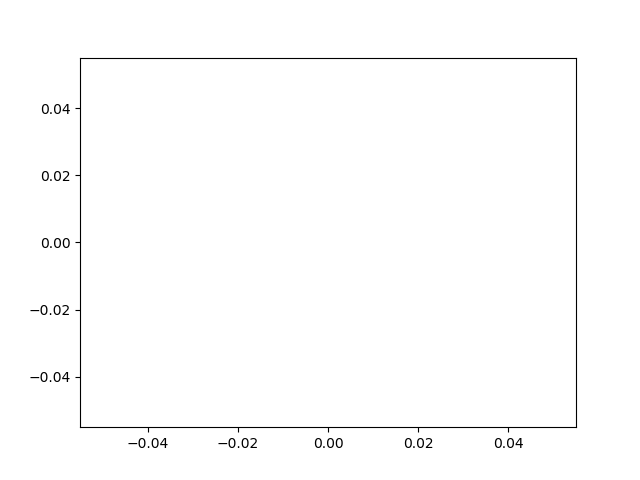

[1520546411.124, 1520546478.074, 1520546550.018, 1520546620.553, 1520546686.233, 1520546757.85, 1520546827.612, 1520546897.208, 1520546965.496, 1520547034.524, 1520547102.877, 1520547171.927, 1520547240.467, 1520547311.035, 1520547380.986, 1520547449.323, 1520547517.614, 1520547586.218, 1520547650.276, 1520547720.134, 1520547788.274, 1520547856.561, 1520547925.185, 1520547993.974, 1520548062.32, 1520548130.63, 1520548198.925, 1520548267.937, 1520548336.685, 1520548405.299, 1520548473.694, 1520548542.236, 1520548610.366, 1520548678.733, 1520548742.899, 1520548812.126, 1520548880.669, 1520548948.595, 1520549016.988, 1520549085.292, 1520549153.761, 1520549222.089, 1520549291.525, 1520549360.713, 1520549429.592, 1520549498.201, 1520549567.117, 1520549635.968, 1520549704.664, 1520549773.226, 1520549841.707, 1520549909.844, 1520549977.951, 1520550046.528, 1520550115.321, 1520550185.807, 1520550254.398, 1520550322.735, 1520550391.701, 1520550461.186, 1520550529.662, 1520550598.593, 1520550667

<ErrorbarContainer object of 3 artists>

In [9]:
roi=1
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
xdata=flatten(assorted['timestamps'])
ydata=np.array(flatten(assorted['retentions'][roi]))
err=np.array(flatten(assorted['errors'][roi]))
fig, ax = plt.subplots()
#print xdata
ax.errorbar(xdata,ydata,yerr=err,label="ROI:{}".format(roi),fmt='o',markersize=3,color=colors[roi],capsize=1)
#xfmt=md.DateFormatter('%H:%M')

In [ ]:
#assorted camera data analysis

assorted={}
assorted['exp_ids']=[]
assorted['timestamps']=[]
assorted['retentions']=[[],[],[],[],[]]
assorted['errors']=[[],[],[],[],[]]
for exp_id in exp_ids:
    container=process_container(exp_id)
    assorted['exp_ids'].append(container['exp_id'])
    assorted['timestamps'].append(container['timestamps'])
    for roi in [0,1,2,3,4]:
        assorted['retentions'][roi].append(container['retentions'][str(roi)])
        assorted['errors'][roi].append(container['errors'][str(roi)])


<IPython.core.display.Javascript object>


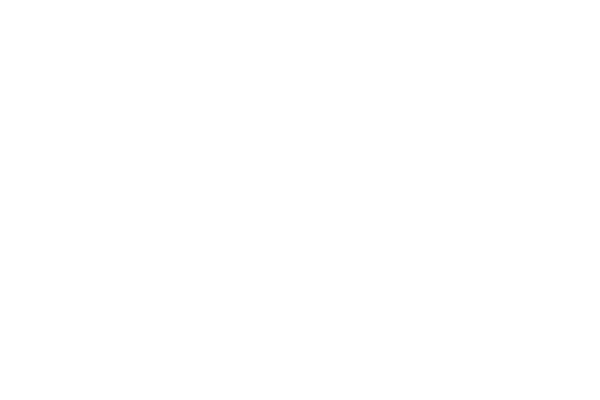

NameError: name 'retention' is not defined

In [5]:
savefig=False
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig, ax = plt.subplots()
fig.set_size_inches(6,4)
fit_guesses=[30,0.4,2,0,0.5]
roi_dependency=[0,0,0,0,0]
fitted_parameters=[]
for roi in [1,2]:
    data = []
    timedata=[]
    reten = []
    err = []
    for e in range(len(np.squeeze(retention['ivar']))):
        data.append(np.squeeze(retention['ivar'])[e][roi])
        reten.append(np.squeeze(retention['retention'])[e][roi])
        err.append(np.squeeze(retention['error'])[e][roi])
    ax.errorbar(dates,reten,yerr=err,label="ROI:{}".format(roi),fmt='o',markersize=3,color=colors[roi],capsize=1)
    ax.xaxis.set_major_formatter(xfmt)
    datemin = dt.datetime(2018, 3, 5,0,0,0)
    datemax = dt.datetime(2018, 3, 5,4,0,0)
    ax.set_xlim(datemin, datemax)

# Analyzing experiments without atoms

In [51]:
keylist=['Red_camera_dataX',
 'Red_camera_dataY',
  'FORT_camera_dataX',
'FORT_camera_dataY',
 'timestamp_measurements',
 'timestamp_iteration']

exp_ids_all=[
        '2018_04_17_10_58_11_780A Ramsey between r1-r2',
         '2018_04_17_11_26_58_780A Ramsey between r1-r2',
         '2018_04_17_12_16_21_780A Ramsey between r1-r2',
         '2018_04_17_12_52_32_780A Ramsey between r1-r2',
         '2018_04_17_13_35_12_Searching 97d52 signal, 780A freq scan',
         '2018_04_17_14_25_14_Searching 97d signal, Blue X scan, 100 pulses',
         '2018_04_17_14_25_14_Searching 97d signal, Blue X scan, 100 pulses',
         '2018_04_17_15_05_10_Searching 97d signal,red freq scan, 100 pulses',
         '2018_04_17_15_30_23_Searching 97d signal,Blue X scan, 100 pulses',
         '2018_04_17_15_48_53_Searching 97d signal,Blue Y scan, 100 pulses',
         '2018_04_17_16_21_34_780A ramsey',
         '2018_04_17_16_51_12_Searching 97d signa, red freq scan, 100 pulses',
         '2018_04_17_17_03_43_Searching 97d signa,Blue X scan, 100 pulses',
         '2018_04_17_17_15_36_Searching 97d signa,Blue X scan, 100 pulses',
         '2018_04_17_17_27_08_Searching 97d signa,Blue Y scan, 100 pulses',
         '2018_04_17_17_44_27_Searching 97d signa,Blue X scan, 100 pulses',
         '2018_04_17_17_59_56_Searching 97d signa,Blue X scan, 100 pulses, 312718.4 GHz',
         '2018_04_17_18_38_17_Searching 97d signa,Blue Y scan, 100 pulses, 312718.4 GHz',
         '2018_04_17_18_55_15_Searching 97d signal,freq scan, 100 pulses, 312718.4 GHz',
         '2018_04_17_19_11_26_Searching 97d signal,vert, 100 pulses, 312718.4 GHz',
         '2018_04_17_19_40_43_Searching 97d signal,vert, 100 pulses, 312718.4 GHz',
         '2018_04_17_20_00_52_Searching 97d signal,horiz, 100 pulses, 312718.4 GHz',
         '2018_04_17_20_09_01_Searching 97d signal,horiz, 100 pulses, 312718.4 GHz',
         '2018_04_17_21_12_34_780A ramsey',
         '2018_04_17_21_56_12_780A ramsey',
         '2018_04_17_22_53_53_780A ramsey',
         '2018_04_18_00_18_33_no atom, closed loop',
         '2018_04_18_01_13_52_no atom, closed loop',
         '2018_04_18_09_49_23_780A ramsey',
         '2018_04_18_10_54_00_780A ramsey',
         '2018_04_18_11_42_28_780A ramsey',
         '2018_04_18_13_19_38_Searching 97d signal,horiz, 100 pulses, 312718.4 GHz',
         '2018_04_18_13_46_22_Searching 97d signal,horiz, 100 pulses',
         '2018_04_18_13_58_28_Ryd 780A TPS, 100 pulses',
         '2018_04_18_14_32_44_Ryd 780A vertical scan, 100 pulses',
         '2018_04_18_15_00_06_Ryd 780A vertical scan, 100 pulses',
         '2018_04_18_15_36_22_Ryd 780A TPS, 100 pulses',
         '2018_04_18_15_57_25_Ryd 780A, Blue X scan, 100 pulses',
         '2018_04_18_16_20_26_Ryd 780A, Blue Y scan, 100 pulses',
         '2018_04_18_17_20_05_Ryd 780A TPS, fine',
         '2018_04_18_18_33_15_Ryd 780A TPS, wide',
         '2018_04_18_19_06_14_Ryd 780A TPS, 97d3 2',
         '2018_04_18_19_25_46_Ryd 780A RFE, 97d3 2',
         '2018_04_18_19_49_00_780A ramsey, closed loop',
         '2018_04_18_20_29_56_780A ramsey, closed loop',
         '2018_04_18_21_20_52_780A ramsey, closed loop',
         '2018_04_18_22_11_27_780A ramsey, closed loop',
         '2018_04_18_23_57_41_no atom, closed loop',
         '2018_04_19_10_22_33_780A ramsey, closed loop',
         '2018_04_19_11_01_05_780A ramsey, closed loop',
         '2018_04_19_15_18_27_780A ramsey, closed loop',
         '2018_04_19_15_43_07_780A ramsey, closed loop',
         '2018_04_19_16_03_22_780A ramsey, closed loop',
         '2018_04_19_16_23_37_780A ramsey, closed loop',
         '2018_04_19_16_46_21_780A ramsey, closed loop',
         '2018_04_19_17_30_17_780A ramsey, closed loop',
         '2018_04_19_22_47_43_780A ramsey, closed loop',
         '2018_04_19_23_20_45_780A ramsey, closed loop',
         '2018_04_19_23_50_26_780A ramsey, closed loop',
         '2018_04_20_00_18_45_780A ramsey, closed loop',
         '2018_04_20_00_44_51_780A ramsey, closed loop',
         '2018_04_20_02_03_45_780A ramsey, closed loop',   
         '2018_04_20_08_32_02_780A ramsey, closed loop',
         '2018_04_20_09_20_41_780A ramsey, closed loop',
         '2018_04_20_10_49_28_780A ramsey, closed loop',
        '2018_04_20_11_47_15_780A ramsey, closed loop',
        '2018_04_20_12_26_31_780A ramsey, closed loop',
        '2018_04_20_13_07_25_780A ramsey, closed loop',
        '2018_04_20_13_49_08_780A ramsey, closed loop',
        '2018_04_20_14_27_42_780A ramsey, closed loop',
        '2018_04_20_14_51_43_780A ramsey, closed loop',
        '2018_04_20_15_21_04_780A ramsey, closed loop',
        '2018_04_20_15_44_45_780A ramsey, closed loop',
        '2018_04_20_16_05_33_780A ramsey, closed loop',
        '2018_04_20_16_23_49_780A ramsey, closed loop',
        '2018_04_20_16_40_40_780A ramsey, closed loop',
        '2018_04_20_17_23_53_780A ramsey, closed loop',
        '2018_04_20_18_10_59_780A ramsey, closed loop',
        '2018_04_20_19_40_13_780A ramsey, closed loop',
        '2018_04_20_20_20_52_780A ramsey, closed loop',
        '2018_04_20_20_45_32_780A ramsey, closed loop',
        '2018_04_20_21_13_28_780A ramsey, closed loop',
        '2018_04_21_14_01_47_780A ramsey, closed loop',
        '2018_04_21_14_39_59_780A ramsey, closed loop',
        '2018_04_21_15_14_06_780A ramsey, closed loop',
        '2018_04_21_15_47_33_780A ramsey, closed loop',
        '2018_04_21_18_53_41_780A ramsey, closed loop'

        ]

exp_ids_RamseysOnly=[
        '2018_04_17_10_58_11_780A Ramsey between r1-r2',
         '2018_04_17_11_26_58_780A Ramsey between r1-r2',
         '2018_04_17_12_16_21_780A Ramsey between r1-r2',
         '2018_04_17_12_52_32_780A Ramsey between r1-r2',
         '2018_04_17_16_21_34_780A ramsey',
         '2018_04_17_21_12_34_780A ramsey',
         '2018_04_17_21_56_12_780A ramsey',
         '2018_04_17_22_53_53_780A ramsey',
         '2018_04_18_09_49_23_780A ramsey',
         '2018_04_18_10_54_00_780A ramsey',
         '2018_04_18_11_42_28_780A ramsey',
         '2018_04_18_19_49_00_780A ramsey, closed loop',
         '2018_04_18_20_29_56_780A ramsey, closed loop',
         '2018_04_18_21_20_52_780A ramsey, closed loop',
         '2018_04_18_22_11_27_780A ramsey, closed loop',
         '2018_04_19_10_22_33_780A ramsey, closed loop',
         '2018_04_19_11_01_05_780A ramsey, closed loop',
         '2018_04_19_15_18_27_780A ramsey, closed loop',
         '2018_04_19_15_43_07_780A ramsey, closed loop',
         '2018_04_19_16_03_22_780A ramsey, closed loop',
         '2018_04_19_16_23_37_780A ramsey, closed loop',
         '2018_04_19_16_46_21_780A ramsey, closed loop',
         '2018_04_19_17_30_17_780A ramsey, closed loop',
         '2018_04_19_22_47_43_780A ramsey, closed loop',
         '2018_04_19_23_20_45_780A ramsey, closed loop',
         '2018_04_19_23_50_26_780A ramsey, closed loop',
         '2018_04_20_00_18_45_780A ramsey, closed loop',
         '2018_04_20_00_44_51_780A ramsey, closed loop',
         '2018_04_20_02_03_45_780A ramsey, closed loop',   
         '2018_04_20_08_32_02_780A ramsey, closed loop',
         '2018_04_20_09_20_41_780A ramsey, closed loop',
         '2018_04_20_10_49_28_780A ramsey, closed loop',
        '2018_04_20_11_47_15_780A ramsey, closed loop',
        '2018_04_20_12_26_31_780A ramsey, closed loop',
           '2018_04_20_13_07_25_780A ramsey, closed loop',
        '2018_04_20_13_49_08_780A ramsey, closed loop',
        '2018_04_20_14_27_42_780A ramsey, closed loop',
        '2018_04_20_14_51_43_780A ramsey, closed loop',
        '2018_04_20_15_21_04_780A ramsey, closed loop',
        '2018_04_20_15_44_45_780A ramsey, closed loop',
        '2018_04_20_16_05_33_780A ramsey, closed loop',
        '2018_04_20_16_23_49_780A ramsey, closed loop',
        '2018_04_20_16_40_40_780A ramsey, closed loop',
        '2018_04_20_17_23_53_780A ramsey, closed loop',
        '2018_04_20_18_10_59_780A ramsey, closed loop',
        '2018_04_20_19_40_13_780A ramsey, closed loop',
        '2018_04_20_20_20_52_780A ramsey, closed loop',
        '2018_04_20_20_45_32_780A ramsey, closed loop',
        '2018_04_20_21_13_28_780A ramsey, closed loop',
        '2018_04_21_14_01_47_780A ramsey, closed loop',
        '2018_04_21_15_47_33_780A ramsey, closed loop'

        ]

exp_ids=exp_ids_all#exp_ids_RamseysOnly
data={}
for j in range(0,len(exp_ids)):
    exp_id=exp_ids[j]
    q=open_data(exp_id)
    e=0
    for i in q.experiments[e]['iterations']:
        for key in keylist:
            if i==0 and j==0:
                data[key]=[]
            try:
                data[key].append(q.experiments[e]['iterations'][i][key])
            except:
                print "error occured : exp {}, iter {}, key {}".format(exp_id, i, key)
    

Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_04_17/2018_04_17_10_58_11_780A Ramsey between r1-r2/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_04_17/2018_04_17_11_26_58_780A Ramsey between r1-r2/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_04_17/2018_04_17_12_16_21_780A Ramsey between r1-r2/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_04_17/2018_04_17_12_52_32_780A Ramsey between r1-r2/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_04_17/2018_04_17_13_35_12_Searching 97d52 signal, 780A freq scan/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_04_17/2018_04_17_14_25_14_Searching 97d signal, Blue X scan, 100 pulses/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y

<IPython.core.display.Javascript object>


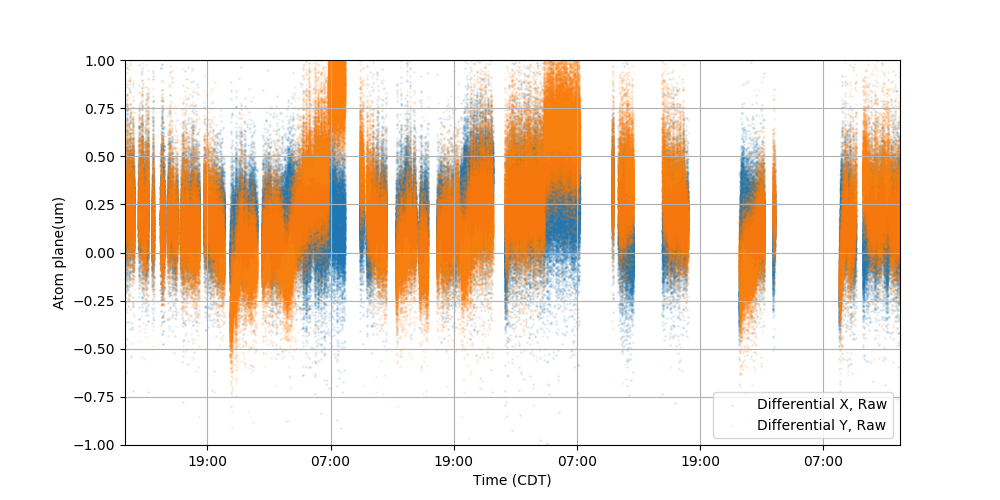

In [37]:
# xfmt=md.DateFormatter('%H:%M')
# dotsize=1
# figW=10
# figH=5
# fig, ax = plt.subplots()
# fig.set_size_inches(figW,figH)
# flattendedtimestamps=np.array(flatten(data[keylist[4]]))
# dates=[dt.datetime.fromtimestamp(ts) for ts in flattendedtimestamps]

# flatteneddata0=np.array(flatten(data[keylist[0]]))
# flatteneddata2=np.array(flatten(data[keylist[2]]))
# ax.xaxis.set_major_formatter(xfmt)
# data_to_plot=flatteneddata0-flatteneddata2
# #data2_to_plot=np.mean(data_to_plot.reshape(-1,100),1)
# ax.scatter(dates,data_to_plot,s=dotsize)
# #ax.plot(dates,data2_to_plot)
# ax.set_xlim(dates[0],dates[-1])

# fig, ax = plt.subplots()
# fig.set_size_inches(figW,figH)
# flatteneddata1=np.array(flatten(data[keylist[1]]))
# flatteneddata3=np.array(flatten(data[keylist[3]]))
# data_to_plot=flatteneddata1-flatteneddata3
# ax.scatter(dates,data_to_plot,s=dotsize)
# ax.xaxis.set_major_formatter(xfmt)
# ax.set_xlim(dates[0],dates[-1])
# Raw plotting
savefig=False
data_cutoff=0
xfmt=md.DateFormatter('%H:%M')
figW=10
figH=5
fig, ax = plt.subplots()
fig.set_size_inches(figW,figH)
flattendedtimestamps=np.array(flatten(data[keylist[4]]))
dates=[dt.datetime.fromtimestamp(ts) for ts in flattendedtimestamps][data_cutoff:]

flatteneddata0=np.array(flatten(data[keylist[0]]))[data_cutoff:]
flatteneddata2=np.array(flatten(data[keylist[2]]))[data_cutoff:]
flatteneddata1=np.array(flatten(data[keylist[1]]))[data_cutoff:]
flatteneddata3=np.array(flatten(data[keylist[3]]))[data_cutoff:]

ax.xaxis.set_major_formatter(xfmt)
data_to_plot=flatteneddata0-flatteneddata2-(flatteneddata0[0]-flatteneddata2[0])
ax.scatter(dates,data_to_plot,s=1,alpha=0.1,label='Differential X, Raw')
ax.set_xlim(dates[0],dates[-1])
ax.set_ylim(-1,1)

data_to_plot2=flatteneddata1-flatteneddata3-(flatteneddata1[0]-flatteneddata3[0])
ax.scatter(dates,data_to_plot2,s=1,alpha=0.1,label='Differential Y, Raw')
ax.grid()
ax.set_xlabel('Time (CDT)')
ax.set_ylabel('Atom plane(um)')
ax.legend()
if savefig:
    plt.savefig('Alignment_over_night.png')

<IPython.core.display.Javascript object>


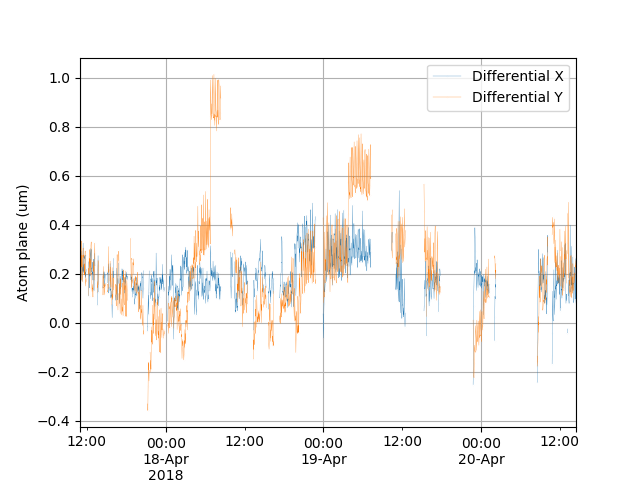

In [41]:
# Using Pandas
import pandas as pd
savefig=False
data_cutoff=0
flattendedtimestamps=np.array(flatten(data[keylist[4]]))
dates=[dt.datetime.fromtimestamp(ts) for ts in flattendedtimestamps][data_cutoff:]

flatteneddata0=np.array(flatten(data[keylist[0]]))[data_cutoff:]
flatteneddata2=np.array(flatten(data[keylist[2]]))[data_cutoff:]
flatteneddata1=np.array(flatten(data[keylist[1]]))[data_cutoff:]
flatteneddata3=np.array(flatten(data[keylist[3]]))[data_cutoff:]

samplerate='100S'
offsetX=(flatteneddata0-flatteneddata2)[0]
offsetY=(flatteneddata1-flatteneddata3)[0]
df=pd.DataFrame({'Differential X': flatteneddata0-flatteneddata2-offsetX,
                 'Differential Y': flatteneddata1-flatteneddata3-offsetY,
                 'Red X': flatteneddata0,
                 'Red Y': flatteneddata1,
                 'FORT X': flatteneddata2,
                 'FORT Y': flatteneddata3
                },index=dates)

## 
data_to_plot2=df.resample(samplerate).mean()
ax=data_to_plot2.plot(y=['Differential X','Differential Y'],lw=0.2,marker='.',markersize=0.02)
#data_to_plot2.plot(y='Differential Y',lw=0.2)
#ax.set_xlabel('Atom plane (um)')
ax.set_ylabel('Atom plane (um)')
ax.grid()
ax.legend()
#plt.savefig('Alignment_20180415.png')

<IPython.core.display.Javascript object>


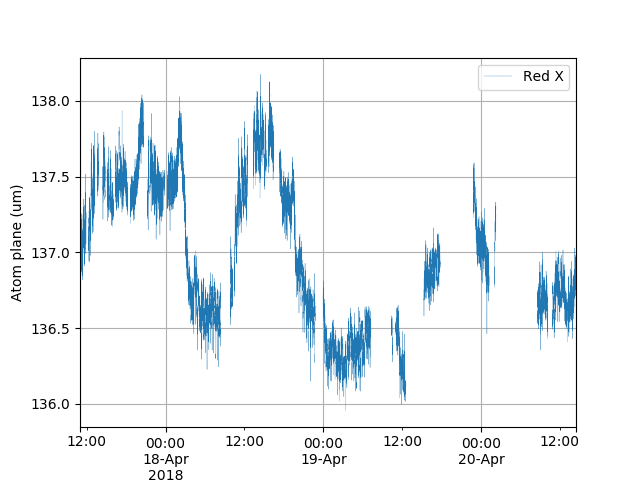

<IPython.core.display.Javascript object>


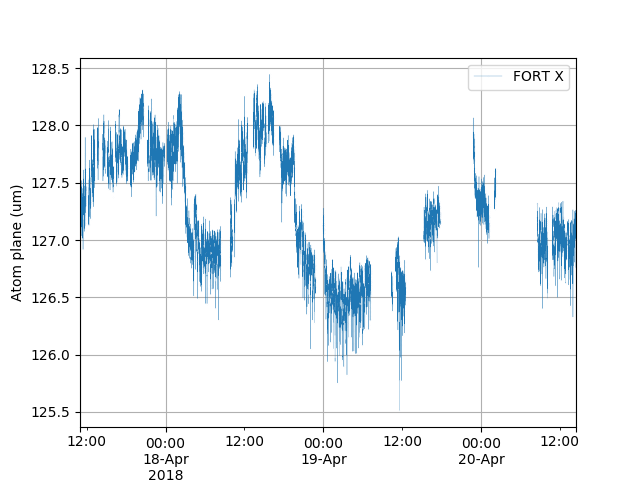

<IPython.core.display.Javascript object>


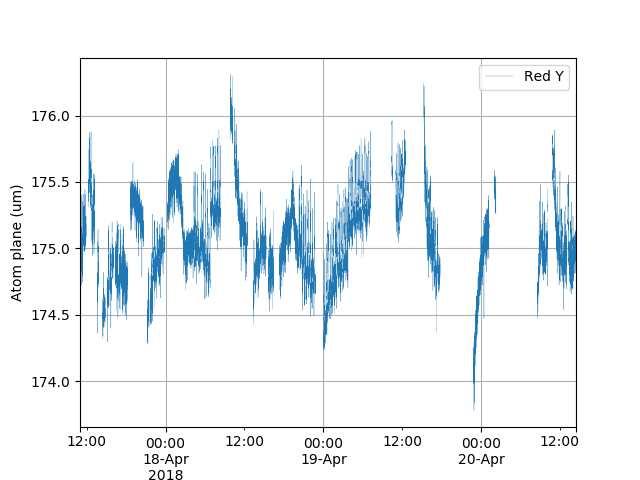

<IPython.core.display.Javascript object>


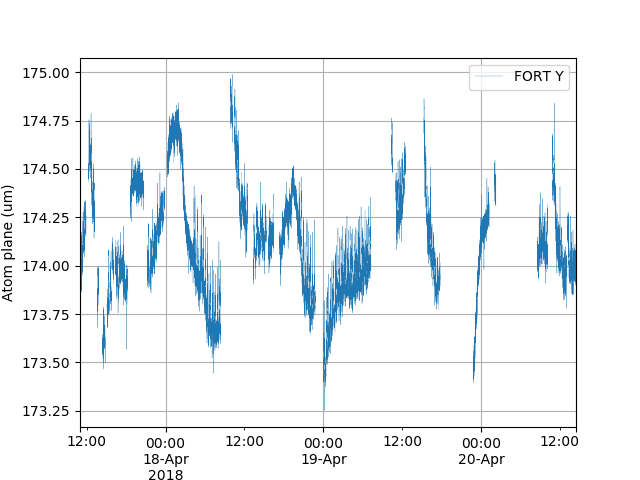

In [42]:
# Using Pandas
import pandas as pd
savefig=False
data_cutoff=0
flattendedtimestamps=np.array(flatten(data[keylist[4]]))
dates=[dt.datetime.fromtimestamp(ts) for ts in flattendedtimestamps][data_cutoff:]

flatteneddata0=np.array(flatten(data[keylist[0]]))[data_cutoff:]
flatteneddata2=np.array(flatten(data[keylist[2]]))[data_cutoff:]
flatteneddata1=np.array(flatten(data[keylist[1]]))[data_cutoff:]
flatteneddata3=np.array(flatten(data[keylist[3]]))[data_cutoff:]

samplerate='10S'
offsetX=(flatteneddata0-flatteneddata2)[0]
offsetY=(flatteneddata1-flatteneddata3)[0]
df=pd.DataFrame({'Differential X': flatteneddata0-flatteneddata2-offsetX,
                 'Differential Y': flatteneddata1-flatteneddata3-offsetY,
                 'Red X': flatteneddata0,
                 'Red Y': flatteneddata1,
                 'FORT X': flatteneddata2,
                 'FORT Y': flatteneddata3
                },index=dates)

## 
data_to_plot2=df.resample(samplerate).mean()
ax=data_to_plot2.plot(y='Red X',lw=0.2,marker='.',markersize=0.02)
ax.set_ylabel('Atom plane (um)')
ax.grid()
ax.legend()

ax=data_to_plot2.plot(y='FORT X',lw=0.2,marker='.',markersize=0.02)
ax.set_ylabel('Atom plane (um)')
ax.grid()
ax.legend()

ax=data_to_plot2.plot(y='Red Y',lw=0.2,marker='.',markersize=0.02)
ax.set_ylabel('Atom plane (um)')
ax.grid()
ax.legend()

ax=data_to_plot2.plot(y='FORT Y',lw=0.2,marker='.',markersize=0.02)
ax.set_ylabel('Atom plane (um)')
ax.grid()
ax.legend()

In [27]:
range(0,20,2)

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18]

In [43]:
# Allan 
tau_list=range(1,501)+range(501,10001,50)+range(10002,100002,200)
samplerates=[]
for i in tau_list:
    samplerates.append('{}S'.format(i))
        
samplerate='1S'

var_list={}

original_resampled=df.resample(samplerate).mean()

for i in range(0,len(tau_list)):
    avg_samplerate=samplerates[i]
    tau=tau_list[i]
    print tau
    #print i
    try:
        downsampled=df.resample(avg_samplerate).mean() # Takes block-average for given time chuck size
        for key in downsampled:
            values=downsampled[key].values
            Xtau=values[1:]
            Xo=values[0:-1]
            var=np.nanmean(np.abs(Xtau-Xo))
            if i==0:
                var_list[key]=[]
            var_list[key].append(var)
    except:
        pass

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


<IPython.core.display.Javascript object>


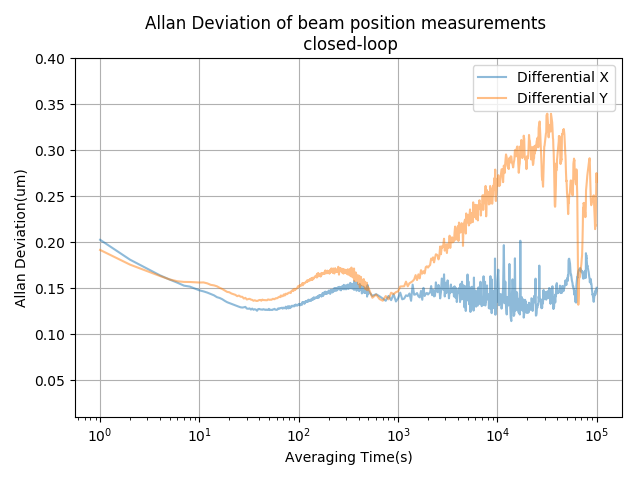

In [45]:
fig, ax = plt.subplots()
#xdata=tau_list
#for key in var_list:
for key in ['Differential X','Differential Y']:
    ax.semilogx(tau_list, np.sqrt(0.5*np.array(var_list[key])),label=key,alpha=0.5)
#ax.semilogx(tau_list, np.sqrt(Yvar_list),label='Diff X',alpha=0.5)
# ax.plot(xdata,np.sqrt(Xvariance_list),label='Diff X',alpha=0.5)
# ax.plot(xdata,np.sqrt(Yvariance_list),label='Diff Y',alpha=0.5)
ax.legend()
#ax.set_xlim(1,)
ax.set_title('Allan Deviation of beam position measurements \n closed-loop')
ax.set_xlabel('Averaging Time(s)')
ax.set_ylabel('Allan Deviation(um)')
#ax.axvline(x=60,color='k',alpha=0.3)
ax.set_ylim(0.01,0.4)
ax.grid()
plt.tight_layout()
savefig=False
if savefig:
    plt.savefig('AllanDeviation_Openloop.png')
    plt.savefig('AllanDeviation_Openloop.pdf')